In [72]:
import pandas as pd
from pandas import datetime
from datetime import timedelta
import matplotlib.pyplot as plt 
import numpy as np
import warnings
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

In [60]:
def parser(x):
    return datetime.strptime(x,'%m/%d/%Y')

cases = pd.read_csv('COVID19_nat_pred_train - Sheet1.csv', index_col=0, parse_dates=[0] ,date_parser=parser)

In [61]:
cases.tail()


,cases_time_series__totalconfirmed
cases_time_series__date,
2020-05-26,150858
2020-05-27,158104
2020-05-28,165358
2020-05-29,173496
2020-05-30,181860


In [69]:
cases.index[1]

Timestamp('2020-01-31 00:00:00')

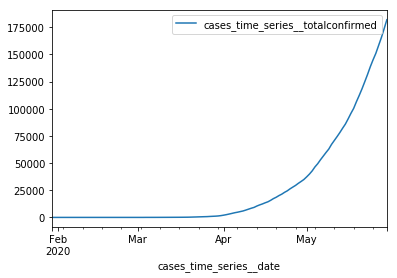

In [52]:
cases.plot()


In [29]:
##Making series stationary, we consider a log transform of the series and difference it twice
cases_d2 = np.log(cases).diff(periods = 2)
cases_d2 = cases_d1[2:]
cases_d2.head()


,cases_time_series__totalconfirmed
cases_time_series__date,
2020-02-01,0.000000
2020-02-02,0.693147
2020-02-03,1.098612
2020-02-04,0.405465
2020-02-05,0.000000


In [30]:
#define function for ADF test

def adf_test(X):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(X, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
adf_test(cases_d1.cases_time_series__totalconfirmed)

Results of Dickey-Fuller Test:
Test Statistic                  -2.991648
p-value                          0.035682
#Lags Used                       4.000000
Number of Observations Used    115.000000
Critical Value (1%)             -3.488535
Critical Value (5%)             -2.887020
Critical Value (10%)            -2.580360
dtype: float64


In [75]:
# evaluate an ARIMA model for a given order (p,d,q)
# P = periods taken from AR model
# d = order of integration
# q = periods in moving average model
def evaluate_arima(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]
    actual = [x for x in train]
    # making predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(actual, order=arima_order)
        model_fit = model.fit(disp=0)
        pred = model_fit.forecast()[0]
        predictions.append(pred)
        actual.append(test[t])
    # calculating mse as measure of accuracy
    mse = mean_squared_error(test, predictions)
    return mse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, pval, dval, qval):
    dataset = dataset.astype('float32')
    best_score, best_order = float("inf"), None
    for p in pval:
        for d in dval:
            for q in qval:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_order = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_order, best_score))
 

pval = [0, 1, 2, 4, 6, 8, 10]
dval = range(0, 3)
qval = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(cases.cases_time_series__totalconfirmed, pval, dval, qval)

ARIMA(0, 0, 0) MSE=6026509043.059
ARIMA(0, 0, 1) MSE=1571793927.506
ARIMA(0, 0, 2) MSE=506657205.470
ARIMA(0, 1, 0) MSE=13689499.759
ARIMA(0, 1, 1) MSE=4431973.125
ARIMA(0, 2, 0) MSE=287426.316
ARIMA(0, 2, 1) MSE=264147.567
ARIMA(0, 2, 2) MSE=276851.942
ARIMA(1, 0, 0) MSE=20062454.488
ARIMA(1, 1, 0) MSE=305373.129
ARIMA(1, 2, 0) MSE=262386.826
ARIMA(1, 2, 1) MSE=268596.423
ARIMA(2, 2, 0) MSE=277244.092
ARIMA(4, 2, 0) MSE=291833.504
Best ARIMA(1, 2, 0) MSE=262386.826


In [76]:
X = cases.cases_time_series__totalconfirmed
test = [190535, 198706, 207615]

model = ARIMA(X,order=(1,2,0))
model_fit = model.fit()
predictions  = model_fit.forecast(steps=7)[0]
predictions

array([190236.93215041, 198703.82717106, 207232.83603729, 215834.02704621,
       224503.76019218, 233243.35145158, 242052.32505761])

In [82]:
mse = mean_squared_error(test,predictions[:3])
mse

78299.4861802376

Text(0.5, 1.0, 'Real vs Predicted Values')

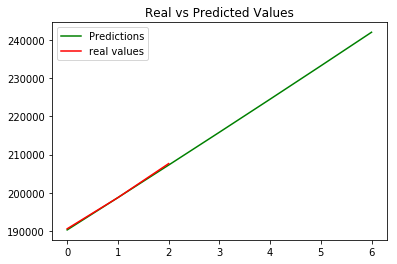

In [38]:
plt.plot(predictions, c='green', label = 'Predictions')
plt.plot(test, c= 'red', label='real values')
plt.legend()
plt.title('Real vs Predicted Values')

##The test values have been taken from the WHO pandemic dashboard for the dates 31-5-20 to 2-6-20.
##We have forecasted from 31-5-20 to 6-6-20, our last data point was on 30-5-20.

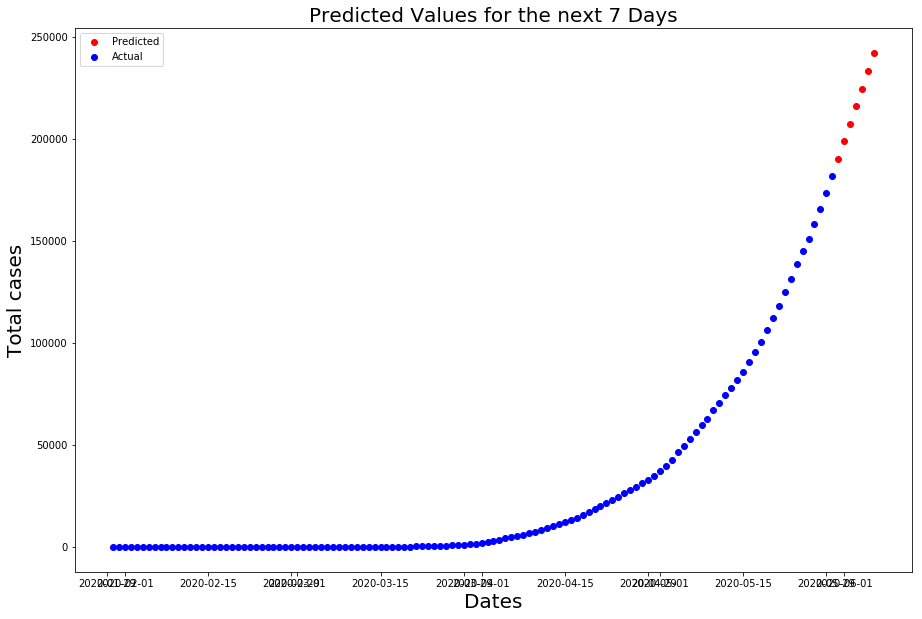

In [74]:

start_date = cases.index.max()
prediction_dates = []
for i in range(7):
    date = start_date + timedelta(days=1)
    prediction_dates.append(date)
    start_date = date
plt.figure(figsize= (15,10))
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Predicted Values for the next 7 Days" , fontsize = 20)

plt.plot_date(y= predictions, x= prediction_dates,color = 'red',label = 'Predicted');
plt.plot_date(y=cases.cases_time_series__totalconfirmed,x=cases.index,color = 'blue',label = 'Actual');
plt.legend();